<a href="https://colab.research.google.com/github/Archii0/U-Net-Autonomous-Driving/blob/main/U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Connect Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Image loading scripts

In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import numpy as np

In [ ]:

# Function to collect all image paths from multiple folders
def get_image_paths(base_dir, sub_dirs, sample_size=None):
    all_image_paths = []
    for sub_dir in sub_dirs:
        image_dir = os.path.join(base_dir, sub_dir, 'camera', 'cam_front_center')
        image_paths = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.png')]
        all_image_paths.extend(image_paths)

    if sample_size and sample_size < len(all_image_paths):
        all_image_paths = random.sample(all_image_paths, sample_size)

    return all_image_paths

# Function to split data
def split_data(image_paths, train_ratio=0.8, val_ratio=0.1):
    total_count = len(image_paths)
    random.shuffle(image_paths)
    train_count = int(total_count * train_ratio)
    val_count = int(total_count * val_ratio)
    train_paths = image_paths[:train_count]
    val_paths = image_paths[train_count:train_count + val_count]
    test_paths = image_paths[train_count + val_count:]
    return train_paths, val_paths, test_paths

# Dataset class
class A2D2Dataset(Dataset):
    def __init__(self, image_paths, mask_base_dir, transform=None):
        self.image_paths = image_paths
        self.mask_base_dir = mask_base_dir
        self.transform = transform

        self.RGB_TO_CLASS = {
          (255, 0, 0): 0,       # Car 1
          (200, 0, 0): 1,       # Car 2
          (150, 0, 0): 2,       # Car 3
          (128, 0, 0): 3,       # Car 4
          (182, 89, 6): 4,      # Bicycle 1
          (150, 50, 4): 5,      # Bicycle 2
          (90, 30, 1): 6,       # Bicycle 3
          (90, 30, 30): 7,      # Bicycle 4
          (204, 153, 255): 8,   # Pedestrian 1
          (189, 73, 155): 9,    # Pedestrian 2
          (239, 89, 191): 10,   # Pedestrian 3
          (255, 128, 0): 11,    # Truck 1
          (200, 128, 0): 12,    # Truck 2
          (150, 128, 0): 13,    # Truck 3
          (0, 255, 0): 14,      # Small vehicles 1
          (0, 200, 0): 15,      # Small vehicles 2
          (0, 150, 0): 16,      # Small vehicles 3
          (0, 128, 255): 17,    # Traffic signal 1
          (30, 28, 158): 18,    # Traffic signal 2
          (60, 28, 100): 19,    # Traffic signal 3
          (0, 255, 255): 20,    # Traffic sign 1
          (30, 220, 220): 21,   # Traffic sign 2
          (60, 157, 199): 22,   # Traffic sign 3
          (255, 255, 0): 23,    # Utility vehicle 1
          (255, 255, 200): 24,  # Utility vehicle 2
          (233, 100, 0): 25,    # Sidebars
          (110, 110, 0): 26,    # Speed bumper
          (128, 128, 0): 27,    # Curbstone
          (255, 193, 37): 28,   # Solid line
          (64, 0, 64): 29,      # Irrelevant signs
          (185, 122, 87): 30,   # Road blocks
          (0, 0, 100): 31,      # Tractor
          (139, 99, 108): 32,   # Non-drivable street
          (210, 50, 115): 33,   # Zebra crossing
          (255, 0, 128): 34,    # Obstacles / trash
          (255, 246, 143): 35,  # Poles
          (150, 0, 150): 36,    # RD restricted area
          (204, 255, 153): 37,  # Animals
          (238, 162, 173): 38,  # Grid structure
          (33, 44, 177): 39,    # Signal corpus
          (180, 50, 180): 40,   # Drivable cobblestone
          (255, 70, 185): 41,   # Electronic traffic
          (238, 233, 191): 42,  # Slow drive area
          (147, 253, 194): 43,  # Nature object
          (150, 150, 200): 44,  # Parking area
          (180, 150, 200): 45,  # Sidewalk
          (72, 209, 204): 46,   # Ego car
          (200, 125, 210): 47,  # Painted driv. instr.
          (159, 121, 238): 48,  # Traffic guide obj.
          (128, 0, 255): 49,    # Dashed line
          (255, 0, 255): 50,    # RD normal street
          (135, 206, 255): 51,  # Sky
          (241, 230, 255): 52,  # Buildings
          (96, 69, 143): 53,    # Blurred area
          (53, 46, 82): 54      # Rain dirt
        }

    def __len__(self):
        return len(self.image_paths)

    def rgb_to_class_index(self, rgb_mask):
        class_mask = np.zeros((rgb_mask.shape[0], rgb_mask.shape[1]), dtype=np.uint8)
        for rgb, class_idx in self.RGB_TO_CLASS.items():
            matches = np.all(rgb_mask == np.array(rgb, dtype=np.uint8), axis=-1)
            class_mask[matches] = class_idx
        return class_mask

    def __getitem__(self, index):
        img_path = self.image_paths[index]
        mask_path = img_path.replace('camera_frontcenter', 'label_frontcenter').replace('camera/cam_front_center', 'label/cam_front_center')
        image = np.array(Image.open(img_path))
        rgb_mask = np.array(Image.open(mask_path))

        class_index_mask = self.rgb_to_class_index(rgb_mask)

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=class_index_mask)
            image = augmentations["image"]
            class_index_mask = augmentations["mask"]

        return image, class_index_mask

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
import torchvision

In [ ]:
class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(DoubleConv, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )
  def forward(self, x):
    return self.conv(x)

# UNET with skip connection (Ambar)

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class UNET(nn.Module):
    def __init__(self, height,width,in_channels, out_channels):
        super(UNET, self).__init__()

        # Load a pre-trained ResNet model
        self.resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

        # Modify the first convolutional layer to accept custom input channels, the orignal ResNet assumes 3 channels
        original_conv1_weight = self.resnet.conv1.weight.data
        new_conv1 = nn.Conv2d(in_channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        with torch.no_grad():
            new_conv1.weight[:, 0:in_channels, :, :] = original_conv1_weight[:, 0:in_channels, :, :]
        self.resnet.conv1 = new_conv1

        # Remove the last fully connected layer, average pool and layer4
        self.encoder = nn.Sequential(*list(self.resnet.children())[:-3])

        # Inspect the output shape after passing through the encoder
        dummy_input = torch.randn((1, in_channels, height, width))
        encoder = self.encoder(dummy_input)
        num_channels_after_encoder = encoder.shape[1]

        # Define features and the input channels for the bottleneck
        features = [1024,512,256,64]
        self.bottleneck = DoubleConv(num_channels_after_encoder, features[0])

        # Decoder
        self.ups = nn.ModuleList()

        for i in range(0,len(features)-1):
           # This stride depends on your image size
           # you want your image height and width to be a multiple of stride**len(features)
           # so this code will work for image whose height and width are multiples of 16 (2**4)
            self.ups.append(
                nn.ConvTranspose2d(features[i], features[i+1], kernel_size=2, stride=2)
            )
            #input channel wrong before
            self.ups.append(DoubleConv(features[i+1]*2, features[i+1],features[i+1]))

        self.ups.append(
                nn.ConvTranspose2d(features[-1], 32, kernel_size=2, stride=2)
            )
            #input channel wrong before
        self.ups.append(DoubleConv(32, 16,16))

        # Final Convolution
        self.final_conv = nn.Conv2d(16, out_channels, kernel_size=1)

    def forward(self, x):

        # Encoder part (ResNet)

        skip_connections= []

        count=0

        x = self.encoder[0](x)
        count+=1

        for layer in self.encoder[1:]:

            x = layer(x)
            if count>1 and count<6 and count!=3:
              skip_connections.append(x)

            count+=1

        # Bottleneck
        x = self.bottleneck(x)
        count=0
        skip_connections.reverse()

        for idx in range(0, len(self.ups), 2):

            x = self.ups[idx](x)
            if(count <len(skip_connections)):

               x = torch.cat((skip_connections[count], x), dim=1)

            count+=1
            x = self.ups[idx + 1](x)

        return self.final_conv(x)

class DoubleConv(nn.Module):
    # (Convolution -> [BatchNorm] -> ReLU) * 2
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

# U-NET Model

# TEST MODEL (with skips connections)

In [ ]:
# Ignore this test function

#height and width have to be multiples of 16
def test(height,width):
  x = torch.randn((3, 3, height, width))
  model = UNET( height, width, in_channels=3, out_channels=55)
  preds = model(x)
  print(preds.shape)
  print(x.shape)
  assert preds.shape == x.shape

In [ ]:
test(608, 608)

Train

In [ ]:
def save_checkpoint(state, epoch_number, directory_path="/content/drive/MyDrive/Archie/"):
  print("=> Saving checkpoint")
  save_location = directory_path + "UNET_Checkpoint" + str(epoch_number + 1) + ".pth.tar"
  torch.save(state, save_location)

def load_checkpoint(checkpoint, model):
  print("=> Loading checkpoint")
  model.load_state_dict(checkpoint["state_dict"])

def get_loaders(train_paths, val_paths, test_paths, mask_base_dir, batch_size, train_transform, val_transform, test_transform, num_workers=4, pin_memory=True):
    train_ds = A2D2Dataset(train_paths, mask_base_dir, transform=train_transform)
    train_loader = DataLoader(train_ds, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory, shuffle=True)

    val_ds = A2D2Dataset(val_paths, mask_base_dir, transform=val_transform)
    val_loader = DataLoader(val_ds, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory, shuffle=False)

    test_ds = A2D2Dataset(test_paths, mask_base_dir, transform=test_transform)
    test_loader = DataLoader(test_ds, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory, shuffle=False)

    return train_loader, val_loader, test_loader

def get_test_loader(test_paths, mask_base_dir, batch_size, test_transform, num_workers=4, pin_memory=True):

  test_ds = A2D2Dataset(test_paths, mask_base_dir, transform=test_transform)
  test_loader = DataLoader(test_ds, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory, shuffle=False)

  return test_loader



In [ ]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import random

In [ ]:
# Hyperparameters
LEARNING_RATE = 1e-4
# DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE = "cpu"
NUM_EPOCHS = 2
NUM_WORKERS = 2
IMAGE_HEIGHT = 512 #1200 # 1208
IMAGE_WIDTH = 512 #1920 # 1920
PIN_MEMORY = True
LOAD_MODEL = False

BASE_DIR = "/content/drive/MyDrive/camera_lidar_semantic2/camera_lidar_semantic/"
MASK_BASE_DIR = BASE_DIR

# DATES = ["20181204_170238", "20181108_091945", "20181204_154421", "20180807_145028", "20181204_191844"]
# DATES = ["20181204_170238"]

# testing date
DATES = ["20180925_124435"]

# all_image_paths = get_image_paths(base_dir="/content/drive/MyDrive/camera_lidar_semantic2/camera_lidar_semantic/", sub_dirs=DATES)
# TRAIN_PATHS, VAL_PATHS, TEST_PATHS = split_data(all_image_paths)


# TEST_PATHS = get_image_paths(base_dir="/content/drive/MyDrive/camera_lidar_semantic2/camera_lidar_semantic/", sub_dirs=DATES)

# TEST_PATHS = get_image_paths(base_dir="/content/drive/MyDrive/Archie/edgecases/", sub_dirs=DATES)
# TEST_PATHS = get_image_paths

file_paths = [f"/content/drive/MyDrive/Archie/edgecases/{i}.jpg" for i in range(1, 74)]
print(file_paths)

TEST_PATHS = file_paths
TEST_PATHS = ["/content/drive/MyDrive/Archie/edgecases/70.jpg", "/content/drive/MyDrive/Archie/edgecases/71.jpeg", "/content/drive/MyDrive/Archie/edgecases/72.jpeg", "/content/drive/MyDrive/Archie/edgecases/73.jpg"]
# TRAIN_PATHS = []
# with open("/content/drive/MyDrive/Archie/text/train_paths.txt", 'r') as file:
#   TRAIN_PATHS = [line.strip() for line in file.readlines()]


# VAL_PATHS = []
# with open("/content/drive/MyDrive/Archie/text/val_paths.txt", 'r') as file:
#   VAL_PATHS = [line.strip() for line in file.readlines()]

# TEST_PATHS = []
# with open("/content/drive/MyDrive/Archie/text/test_paths.txt", 'r') as file:
#   TEST_PATHS = [line.strip() for line in file.readlines()]


# with open('/content/drive/MyDrive/Archie/text/train_paths.txt', 'w') as f:
#     for item in TRAIN_PATHS:
#         f.write(f"{item}\n")


# with open('/content/drive/MyDrive/Archie/text/val_paths.txt', 'w') as f:
#     for item in VAL_PATHS:
#         f.write(f"{item}\n")

# with open('/content/drive/MyDrive/Archie/text/test_paths.txt', 'w') as f:
#     for item in TEST_PATHS:
#         f.write(f"{item}\n")



# Old code
# SUB_DIRS = ['20180807_145028', '20180810_142822', '20180925_101535', '20180925_124435', '20180925_135056', '20181008_095521', '20181016_082154', '20181016_095036', '20181016_125231', '20181107_132300', '20181107_132730', '20181107_133258', '20181107_133445', '20181108_084007', '20181108_103155', '20181108_123750', '20181108_141609', '20181204_135952', '20181204_154421', '20181204_170238', '20181204_191844', '20181108_091945']
#  201809_25112730 exluded as incomplete folder
# CHOSEN_SUB_DIRS = random.sample(SUB_DIRS, 6)
# print(CHOSEN_SUB_DIRS)

['/content/drive/MyDrive/Archie/edgecases/1.jpg', '/content/drive/MyDrive/Archie/edgecases/2.jpg', '/content/drive/MyDrive/Archie/edgecases/3.jpg', '/content/drive/MyDrive/Archie/edgecases/4.jpg', '/content/drive/MyDrive/Archie/edgecases/5.jpg', '/content/drive/MyDrive/Archie/edgecases/6.jpg', '/content/drive/MyDrive/Archie/edgecases/7.jpg', '/content/drive/MyDrive/Archie/edgecases/8.jpg', '/content/drive/MyDrive/Archie/edgecases/9.jpg', '/content/drive/MyDrive/Archie/edgecases/10.jpg', '/content/drive/MyDrive/Archie/edgecases/11.jpg', '/content/drive/MyDrive/Archie/edgecases/12.jpg', '/content/drive/MyDrive/Archie/edgecases/13.jpg', '/content/drive/MyDrive/Archie/edgecases/14.jpg', '/content/drive/MyDrive/Archie/edgecases/15.jpg', '/content/drive/MyDrive/Archie/edgecases/16.jpg', '/content/drive/MyDrive/Archie/edgecases/17.jpg', '/content/drive/MyDrive/Archie/edgecases/18.jpg', '/content/drive/MyDrive/Archie/edgecases/19.jpg', '/content/drive/MyDrive/Archie/edgecases/20.jpg', '/conten

In [ ]:
len(all_image_paths)

7345

In [ ]:
len(TEST_PATHS)

74

In [ ]:
BATCH_SIZE = 1

In [ ]:
NUM_EPOCHS = 10

In [ ]:
print(TEST_PATHS)

['/content/drive/MyDrive/camera_lidar_semantic2/camera_lidar_semantic/20181204_170238/camera/cam_front_center/20181204170238_camera_frontcenter_000091050.png', '/content/drive/MyDrive/camera_lidar_semantic2/camera_lidar_semantic/20181204_191844/camera/cam_front_center/20181204191844_camera_frontcenter_000011535.png', '/content/drive/MyDrive/camera_lidar_semantic2/camera_lidar_semantic/20181204_191844/camera/cam_front_center/20181204191844_camera_frontcenter_000013322.png', '/content/drive/MyDrive/camera_lidar_semantic2/camera_lidar_semantic/20181108_091945/camera/cam_front_center/20181108091945_camera_frontcenter_000059295.png', '/content/drive/MyDrive/camera_lidar_semantic2/camera_lidar_semantic/20181204_154421/camera/cam_front_center/20181204154421_camera_frontcenter_000083118.png', '/content/drive/MyDrive/camera_lidar_semantic2/camera_lidar_semantic/20180807_145028/camera/cam_front_center/20180807145028_camera_frontcenter_000006176.png', '/content/drive/MyDrive/camera_lidar_semantic

### Functions to export some example images

In [ ]:
import os
import torch
from torchvision import transforms
import numpy as np
from PIL import Image

def save_predictions_as_imgs(loader, model, folder="output/", device=DEVICE):
    """
    Saves the predictions of the model for the given loader as images.

    Args:
    loader (DataLoader): DataLoader containing the dataset.
    model (torch.nn.Module): The trained model for generating predictions.
    folder (str): The folder where images should be saved.
    device (str): The device to run the model on ('cpu' or 'cuda').
    """
    model.eval()  # Set the model to evaluation mode

    # Create output folder if it does not exist
    if not os.path.exists(folder):
        os.makedirs(folder)

    # Loop over the dataset
    for i, (images, _) in enumerate(loader):
        images = images.to(device)

        with torch.no_grad():  # No need to track gradients
            outputs = model(images)

        # Convert model output to images
        for j, output in enumerate(outputs):
            output_img = output_processing(output)
            img = Image.fromarray(output_img)
            img.save(os.path.join(folder, f"prediction_{i+j+1}.png"))
            print("Image: " + str(i+j+1))

    model.train()

def output_processing(output_tensor):
    """
    Converts the output tensor from the model to an RGB image.
    """
    # Convert to a class index map
    class_map = torch.argmax(output_tensor, dim=0)

    # Define your specific color mapping
    color_mapping = {
    0: (255, 0, 0),       # Car 1
    1: (200, 0, 0),       # Car 2
    2: (150, 0, 0),       # Car 3
    3: (128, 0, 0),       # Car 4
    4: (182, 89, 6),      # Bicycle 1
    5: (150, 50, 4),      # Bicycle 2
    6: (90, 30, 1),       # Bicycle 3
    7: (90, 30, 30),      # Bicycle 4
    8: (204, 153, 255),   # Pedestrian 1
    9: (189, 73, 155),    # Pedestrian 2
    10: (239, 89, 191),   # Pedestrian 3
    11: (255, 128, 0),    # Truck 1
    12: (200, 128, 0),    # Truck 2
    13: (150, 128, 0),    # Truck 3
    14: (0, 255, 0),      # Small vehicles 1
    15: (0, 200, 0),      # Small vehicles 2
    16: (0, 150, 0),      # Small vehicles 3
    17: (0, 128, 255),    # Traffic signal 1
    18: (30, 28, 158),    # Traffic signal 2
    19: (60, 28, 100),    # Traffic signal 3
    20: (0, 255, 255),    # Traffic sign 1
    21: (30, 220, 220),   # Traffic sign 2
    22: (60, 157, 199),   # Traffic sign 3
    23: (255, 255, 0),    # Utility vehicle 1
    24: (255, 255, 200),  # Utility vehicle 2
    25: (233, 100, 0),    # Sidebars
    26: (110, 110, 0),    # Speed bumper
    27: (128, 128, 0),    # Curbstone
    28: (255, 193, 37),   # Solid line
    29: (64, 0, 64),      # Irrelevant signs
    30: (185, 122, 87),   # Road blocks
    31: (0, 0, 100),      # Tractor
    32: (139, 99, 108),   # Non-drivable street
    33: (210, 50, 115),   # Zebra crossing
    34: (255, 0, 128),    # Obstacles / trash
    35: (255, 246, 143),  # Poles
    36: (150, 0, 150),    # RD restricted area
    37: (204, 255, 153),  # Animals
    38: (238, 162, 173),  # Grid structure
    39: (33, 44, 177),    # Signal corpus
    40: (180, 50, 180),   # Drivable cobblestone
    41: (255, 70, 185),   # Electronic traffic
    42: (238, 233, 191),  # Slow drive area
    43: (147, 253, 194),  # Nature object
    44: (150, 150, 200),  # Parking area
    45: (180, 150, 200),  # Sidewalk
    46: (72, 209, 204),   # Ego car
    47: (200, 125, 210),  # Painted driv. instr.
    48: (159, 121, 238),  # Traffic guide obj.
    49: (128, 0, 255),    # Dashed line
    50: (255, 0, 255),    # RD normal street
    51: (135, 206, 255),  # Sky
    52: (241, 230, 255),  # Buildings
    53: (96, 69, 143),    # Blurred area
    54: (53, 46, 82)      # Rain dirt
}

    # Decode the segmentation mask
    decoded_image = decode_segmentation_masks(class_map.cpu().numpy(), color_mapping)
    return decoded_image

def decode_segmentation_masks(mask, color_mapping):
    """
    Convert a one-channel segmentation mask to a 3-channel RGB image.
    """
    height, width = mask.shape
    rgb_image = np.zeros((height, width, 3), dtype=np.uint8)

    for class_id, color in color_mapping.items():
        rgb_image[mask == class_id] = color

    return rgb_image

### Evaluate Model Function

In [ ]:
from tensorflow.keras.metrics import MeanIoU


def evaluate_model(model, loader, num_classes, device=DEVICE):
    """
    Evaluates the given model using the Mean Intersection Over Union (IoU) metric.

    Args:
    model (torch.nn.Module): The trained model for generating predictions.
    loader (DataLoader): DataLoader containing the dataset for evaluation.
    num_classes (int): The number of classes in the segmentation task.
    device (str): The device to run the model on ('cpu' or 'cuda').

    Returns:
    float: The mean IoU score.
    """
    model.eval()  # Set the model to evaluation mode
    mean_iou = MeanIoU(num_classes=num_classes)

    with torch.no_grad():  # No need to track gradients during evaluation
        for images, true_masks in loader:
            images = images.to(device)
            true_masks = true_masks.to(device)
            pred_masks = model(images)

            # Convert predictions to class indices
            pred_masks = torch.argmax(pred_masks, dim=1)

            # Update mean IoU with current batch
            mean_iou.update_state(true_masks.cpu().numpy(), pred_masks.cpu().numpy())

    return mean_iou.result().numpy()

### Training function

In [ ]:
def train_fn(loader, model, optimizer, loss_fn, scaler):
  model.train() # Added this but not sure if needed
  loop = tqdm(loader)

  for batch_idx, (data, targets) in enumerate(loop):
    data = data.to(device=DEVICE)
    targets = targets.long()
    # targets = targets.float()
    targets = targets.to(device=DEVICE)

    # forward
    with torch.cuda.amp.autocast():
      predictions = model(data)
      loss = loss_fn(predictions, targets)

    # backward
    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    # update tqdm loop
    loop.set_postfix(loss=loss.item())

def run():
  train_transform = A.Compose(
      [
          A.CenterCrop(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
          A.Normalize(
              mean=[0.0, 0.0, 0.0],
              std=[1.0, 1.0, 1.0],
              max_pixel_value=255.0,
          ),
          ToTensorV2(),
      ],
  )

  val_transform = A.Compose(
      [
          A.CenterCrop(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
          A.Normalize(
              mean=[0.0, 0.0, 0.0],
              std=[1.0, 1.0, 1.0],
              max_pixel_value=255.0,
          ),
          ToTensorV2(),
      ],
  )

  test_transform = A.Compose(
      [
          A.CenterCrop(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
          A.Normalize(
              mean=[0.0, 0.0, 0.0],
              std=[1.0, 1.0, 1.0],
              max_pixel_value=255.0,
          ),
          ToTensorV2(),
      ]
  )

  # for different classes, change out_channels to the number of classes
  model = UNET(512, 512, in_channels=3, out_channels=55).to(DEVICE)

  checkpoint = torch.load('/content/drive/MyDrive/Archie/UNET_Checkpoint8.pth.tar')
  model.load_state_dict(checkpoint['state_dict'])
  # optimizer.load_state_dict(checkpoint['optimizer'])


  loss_fn = nn.CrossEntropyLoss()
  # binary cross entropy loss for 1 class
  # cross entropy loss for multiple classes

  optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

  train_loader, val_loader, test_loader = get_loaders(TRAIN_PATHS, VAL_PATHS, TEST_PATHS, MASK_BASE_DIR, BATCH_SIZE, train_transform, val_transform, test_transform, NUM_WORKERS, PIN_MEMORY)

  scaler = torch.cuda.amp.GradScaler()
  for epoch in range(NUM_EPOCHS):
    train_fn(train_loader, model, optimizer, loss_fn, scaler)

    # save model
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    save_checkpoint(checkpoint, epoch_number = epoch + 9)

    # print("Evaluating model...")
    # mean_iou_score = evaluate_model(model, val_loader, num_classes=55, device='cuda')
    # print(f"Mean IoU score: {mean_iou_score}")


    total_loss = 0.0
    total_samples = 0
    with torch.no_grad():
      for data, targets in val_loader:
        targets = targets.long()
        data, targets = data.to(DEVICE), targets.to(DEVICE)

        # Forward pass
        predictions = model(data)

        # Calculate the loss
        loss = loss_fn(predictions, targets)

        # Update the total loss and number of samples
        total_loss += loss.item()
        total_samples += targets.size(0)

    # Calculate the average validation loss
    average_loss = total_loss / total_samples
    print(f'Validation Loss: {average_loss}')

    # print examples to a folder
    if epoch == NUM_EPOCHS - 1:
      print("Attempting to print to folder...")
      save_predictions_as_imgs(
          val_loader, model, folder="/content/drive/MyDrive/Archie/output", device=DEVICE
      )
      print("Success")

      print("Testing model on train dataset")
  print("Evaluating model...")
  mean_iou_score = evaluate_model(model, test_loader, num_classes=55, device='cuda')
  print(f"Mean IoU score: {mean_iou_score}")


In [ ]:
def train_fn(loader, model, optimizer, loss_fn, scaler):
  model.train() # Added this but not sure if needed
  loop = tqdm(loader)

  for batch_idx, (data, targets) in enumerate(loop):
    data = data.to(device=DEVICE)
    targets = targets.long()
    # targets = targets.float()
    targets = targets.to(device=DEVICE)

    # forward
    with torch.cuda.amp.autocast():
      predictions = model(data)
      loss = loss_fn(predictions, targets)

    # backward
    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    # update tqdm loop
    loop.set_postfix(loss=loss.item())

def run():
  train_transform = A.Compose(
      [
          A.CenterCrop(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
          A.Normalize(
              mean=[0.0, 0.0, 0.0],
              std=[1.0, 1.0, 1.0],
              max_pixel_value=255.0,
          ),
          ToTensorV2(),
      ],
  )

  val_transform = A.Compose(
      [
          A.CenterCrop(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
          A.Normalize(
              mean=[0.0, 0.0, 0.0],
              std=[1.0, 1.0, 1.0],
              max_pixel_value=255.0,
          ),
          ToTensorV2(),
      ],
  )

  test_transform = A.Compose(
      [
          A.CenterCrop(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
          A.Normalize(
              mean=[0.0, 0.0, 0.0],
              std=[1.0, 1.0, 1.0],
              max_pixel_value=255.0,
          ),
          ToTensorV2(),
      ]
  )

  # for different classes, change out_channels to the number of classes
  model = UNET(512, 512, in_channels=3, out_channels=55).to(DEVICE)

  checkpoint = torch.load('/content/drive/MyDrive/Archie/UNET_Checkpoint11.pth.tar')
  model.load_state_dict(checkpoint['state_dict'])
  # optimizer.load_state_dict(checkpoint['optimizer'])


  loss_fn = nn.CrossEntropyLoss()
  # binary cross entropy loss for 1 class
  # cross entropy loss for multiple classes

  optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

  # train_loader, val_loader, test_loader = get_loaders(TRAIN_PATHS, VAL_PATHS, TEST_PATHS, MASK_BASE_DIR, BATCH_SIZE, train_transform, val_transform, test_transform, NUM_WORKERS, PIN_MEMORY)


  test_loader = get_test_loader(TEST_PATHS, MASK_BASE_DIR, BATCH_SIZE, test_transform, NUM_WORKERS, PIN_MEMORY)
  # scaler = torch.cuda.amp.GradScaler()

  print("Evaluating model...")
  mean_iou_score = evaluate_model(model, test_loader, num_classes=55, device='cuda')
  print(f"Mean IoU score: {mean_iou_score}")
  # for epoch in range(NUM_EPOCHS):
  #   train_fn(train_loader, model, optimizer, loss_fn, scaler)

  #   # save model
  #   checkpoint = {
  #       "state_dict": model.state_dict(),
  #       "optimizer": optimizer.state_dict(),
  #   }
  #   save_checkpoint(checkpoint, epoch_number = epoch + 9)

    # print("Evaluating model...")
    # mean_iou_score = evaluate_model(model, val_loader, num_classes=55, device='cuda')
    # print(f"Mean IoU score: {mean_iou_score}")


    # total_loss = 0.0
    # total_samples = 0
    # with torch.no_grad():
    #   for data, targets in val_loader:
    #     targets = targets.long()
    #     data, targets = data.to(DEVICE), targets.to(DEVICE)

    #     # Forward pass
    #     predictions = model(data)

    #     # Calculate the loss
    #     loss = loss_fn(predictions, targets)

    #     # Update the total loss and number of samples
    #     total_loss += loss.item()
    #     total_samples += targets.size(0)

    # Calculate the average validation loss
    # average_loss = total_loss / total_samples
    # print(f'Validation Loss: {average_loss}')

    # print examples to a folder
    # if epoch == NUM_EPOCHS - 1:
    #   print("Attempting to print to folder...")
    #   save_predictions_as_imgs(
    #       val_loader, model, folder="/content/drive/MyDrive/Archie/output", device=DEVICE
    #   )
    #   print("Success")

    #   print("Testing model on train dataset")
  # print("Evaluating model...")
  # mean_iou_score = evaluate_model(model, test_loader, num_classes=55, device='cuda')
  # print(f"Mean IoU score: {mean_iou_score}")


### Run some images through the model

In [ ]:
def run():
  train_transform = A.Compose(
      [
          A.CenterCrop(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
          A.Normalize(
              mean=[0.0, 0.0, 0.0],
              std=[1.0, 1.0, 1.0],
              max_pixel_value=255.0,
          ),
          ToTensorV2(),
      ],
  )

  val_transform = A.Compose(
      [
          A.CenterCrop(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
          A.Normalize(
              mean=[0.0, 0.0, 0.0],
              std=[1.0, 1.0, 1.0],
              max_pixel_value=255.0,
          ),
          ToTensorV2(),
      ],
  )

  test_transform = A.Compose(
      [
          A.CenterCrop(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
          A.Normalize(
              mean=[0.0, 0.0, 0.0],
              std=[1.0, 1.0, 1.0],
              max_pixel_value=255.0,
          ),
          ToTensorV2(),
      ]
  )

  # for different classes, change out_channels to the number of classes
  model = UNET(512, 512, in_channels=3, out_channels=55).to(DEVICE)

  checkpoint = torch.load('/content/drive/MyDrive/Archie/UNET_Checkpoint11.pth.tar', map_location=torch.device('cpu'))
  model.load_state_dict(checkpoint['state_dict'])
  # optimizer.load_state_dict(checkpoint['optimizer'])


  # loss_fn = nn.CrossEntropyLoss()
  # binary cross entropy loss for 1 class
  # cross entropy loss for multiple classes

  # optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

  # train_loader, val_loader, test_loader = get_loaders(TRAIN_PATHS, VAL_PATHS, TEST_PATHS, MASK_BASE_DIR, BATCH_SIZE, train_transform, val_transform, test_transform, NUM_WORKERS, PIN_MEMORY)


  test_loader = get_test_loader(TEST_PATHS, MASK_BASE_DIR, BATCH_SIZE, test_transform, NUM_WORKERS, PIN_MEMORY)

  # test_ds = A2D2Dataset(test_paths, mask_base_dir, transform=test_transform)
  # test_loader = DataLoader(test_ds, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory, shuffle=False)

  # scaler = torch.cuda.amp.GradScaler()

  save_predictions_as_imgs(test_loader, model, folder = "/content/drive/MyDrive/Archie/ICUR", device=DEVICE)

  # print("Evaluating model...")
  # mean_iou_score = evaluate_model(model, test_loader, num_classes=55, device='cuda')
  # print(f"Mean IoU score: {mean_iou_score}")

    # print examples to a folder
    # if epoch == NUM_EPOCHS - 1:
    #   print("Attempting to print to folder...")
    #   save_predictions_as_imgs(
    #       val_loader, model, folder="/content/drive/MyDrive/Archie/output", device=DEVICE
    #   )
    #   print("Success")

  print("Success!")


### Confusion Matrix

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np

def plot_matrix(data):
    y_labels = [
        "Car 1", "Car 2", "Car 3", "Car 4",
        "Bicycle 1", "Bicycle 2", "Bicycle 3", "Bicycle 4",
        "Pedestrian 1", "Pedestrian 2", "Pedestrian 3",
        "Truck 1", "Truck 2", "Truck 3",
        "Small vehicles 1", "Small vehicles 2", "Small vehicles 3",
        "Traffic signal 1", "Traffic signal 2", "Traffic signal 3",
        "Traffic sign 1", "Traffic sign 2", "Traffic sign 3",
        "Utility vehicle 1", "Utility vehicle 2",
        "Sidebars", "Speed bumper", "Curbstone", "Solid line",
        "Irrelevant signs", "Road blocks", "Tractor",
        "Non-drivable street", "Zebra crossing", "Obstacles / trash", "Poles",
        "RD restricted area", "Animals", "Grid structure", "Signal corpus",
        "Drivable cobblestone", "Electronic traffic", "Slow drive area",
        "Nature object", "Parking area", "Sidewalk", "Ego car",
        "Painted driv. instr.", "Traffic guide obj.", "Dashed line",
        "RD normal street", "Sky", "Buildings", "Blurred area", "Rain dirt"
    ]

    x_labels = [
        "Car 1", "Car 2", "Car 3", "Car 4",
        "Bicycle 1", "Bicycle 2", "Bicycle 3", "Bicycle 4",
        "Pedestrian 1", "Pedestrian 2", "Pedestrian 3",
        "Truck 1", "Truck 2", "Truck 3",
        "Small vehicles 1", "Small vehicles 2", "Small vehicles 3",
        "Traffic signal 1", "Traffic signal 2", "Traffic signal 3",
        "Traffic sign 1", "Traffic sign 2", "Traffic sign 3",
        "Utility vehicle 1", "Utility vehicle 2",
        "Sidebars", "Speed bumper", "Curbstone", "Solid line",
        "Irrelevant signs", "Road blocks", "Tractor",
        "Non-drivable street", "Zebra crossing", "Obstacles / trash", "Poles",
        "RD restricted area", "Animals", "Grid structure", "Signal corpus",
        "Drivable cobblestone", "Electronic traffic", "Slow drive area",
        "Nature object", "Parking area", "Sidewalk", "Ego car",
        "Painted driv. instr.", "Traffic guide obj.", "Dashed line",
        "RD normal street", "Sky", "Buildings", "Blurred area", "Rain dirt"
    ]

    # Create a list to store the indices of non-empty columns
    non_empty_columns = [i for i, col in enumerate(data.T) if any(col)]

    # Remove empty columns and corresponding rows
    data_filtered = data[:, non_empty_columns]
    axis_labels_filtered = [label for i, label in enumerate(axis_labels) if i in non_empty_columns]

    # Normalize each row to represent the percentage of the total in its row
    data_percentage = (data_filtered.T / data_filtered.sum(axis=1)).T * 100

    # Calculate column sums
    col_sums = np.sum(data_filtered, axis=0)

    # Convert data to percentages
    percentage_matrix = (data_filtered / col_sums) * 100

    # Create the heatmap
    hm = sn.heatmap(data=percentage_matrix, xticklabels=axis_labels_filtered, yticklabels=axis_labels_filtered)

    print(percentage_matrix)
    # Set the font size
    font = {'size': 4}
    plt.rc('font', **font)

    # Set the title and labels
    plt.title("Image Segmentation Decision Matrix (Percentage)")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")

    # Display the figure
    plt.show()

# Example usage
# Sample data



In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np

def plot_matrix(data):
    # Calculate column sums


    labels = [
      "Car 1",
      "Car 2",
      "Car 3",
      "Car 4",
      "Bicycle 1",
      "Bicycle 2",
      "Bicycle 3",
      "Bicycle 4",
      "Pedestrian 1",
      "Pedestrian 2",
      "Pedestrian 3",
      "Truck 1",
      "Truck 2",
      "Truck 3",
      "Small vehicles 1",
      "Small vehicles 2",
      "Small vehicles 3",
      "Traffic signal 1",
      "Traffic signal 2",
      "Traffic signal 3",
      "Traffic sign 1",
      "Traffic sign 2",
      "Traffic sign 3",
      "Utility vehicle 1",
      "Utility vehicle 2",
      "Sidebars",
      "Speed bumper",
      "Curbstone",
      "Solid line",
      "Irrelevant signs",
      "Road blocks",
      "Tractor",
      "Non-drivable street",
      "Zebra crossing",
      "Obstacles / trash",
      "Poles",
      "RD restricted area",
      "Animals",
      "Grid structure",
      "Signal corpus",
      "Drivable cobblestone",
      "Electronic traffic",
      "Slow drive area",
      "Nature object",
      "Parking area",
      "Sidewalk",
      "Ego car",
      "Painted driv. instr.",
      "Traffic guide obj.",
      "Dashed line",
      "RD normal street",
      "Sky",
      "Buildings",
      "Blurred area",
      "Rain dirt"
  ]
    # Convert data to percentages


    # Remove empty rows and columns
    non_empty_rows = np.any(data != 0, axis=1)
    non_empty_cols = np.any(data != 0, axis=0)

    filtered_data = data[non_empty_rows][:, non_empty_cols]
    filtered_labels = [label for i, label in enumerate(labels) if non_empty_rows[i] and non_empty_cols[i]]


    col_sums = np.sum(filtered_data, axis=0)
    percentage_matrix = (filtered_data / col_sums) * 100
    hm = sn.heatmap(data=percentage_matrix, xticklabels=filtered_labels, yticklabels=filtered_labels)

    font = {'size': 4}
    plt.rc('font', **font)

    plt.title("Image Segmentation Decision Matrix (Percentages)")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")

    plt.show()

# Example usage:
# Replace 'your_data' and 'your_labels' with your actual data and labels



In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt

def plot_matrix(data):

  x_labels = [
      "Car 1",
      "Car 2",
      "Car 3",
      "Car 4",
      "Bicycle 1",
      "Bicycle 2",
      "Bicycle 3",
      "Bicycle 4",
      "Pedestrian 1",
      "Pedestrian 2",
      "Pedestrian 3",
      "Truck 1",
      "Truck 2",
      "Truck 3",
      "Small vehicles 1",
      "Small vehicles 2",
      "Small vehicles 3",
      "Traffic signal 1",
      "Traffic signal 2",
      "Traffic signal 3",
      "Traffic sign 1",
      "Traffic sign 2",
      "Traffic sign 3",
      "Utility vehicle 1",
      "Utility vehicle 2",
      "Sidebars",
      "Speed bumper",
      "Curbstone",
      "Solid line",
      "Irrelevant signs",
      "Road blocks",
      "Tractor",
      "Non-drivable street",
      "Zebra crossing",
      "Obstacles / trash",
      "Poles",
      "RD restricted area",
      "Animals",
      "Grid structure",
      "Signal corpus",
      "Drivable cobblestone",
      "Electronic traffic",
      "Slow drive area",
      "Nature object",
      "Parking area",
      "Sidewalk",
      "Ego car",
      "Painted driv. instr.",
      "Traffic guide obj.",
      "Dashed line",
      "RD normal street",
      "Sky",
      "Buildings",
      "Blurred area",
      "Rain dirt"
  ]

  y_labels = [
      "Car 1",
      "Car 2",
      "Car 3",
      "Car 4",
      "Bicycle 1",
      "Bicycle 2",
      "Bicycle 3",
      "Bicycle 4",
      "Pedestrian 1",
      "Pedestrian 2",
      "Pedestrian 3",
      "Truck 1",
      "Truck 2",
      "Truck 3",
      "Small vehicles 1",
      "Small vehicles 2",
      "Small vehicles 3",
      "Traffic signal 1",
      "Traffic signal 2",
      "Traffic signal 3",
      "Traffic sign 1",
      "Traffic sign 2",
      "Traffic sign 3",
      "Utility vehicle 1",
      "Utility vehicle 2",
      "Sidebars",
      "Speed bumper",
      "Curbstone",
      "Solid line",
      "Irrelevant signs",
      "Road blocks",
      "Tractor",
      "Non-drivable street",
      "Zebra crossing",
      "Obstacles / trash",
      "Poles",
      "RD restricted area",
      "Animals",
      "Grid structure",
      "Signal corpus",
      "Drivable cobblestone",
      "Electronic traffic",
      "Slow drive area",
      "Nature object",
      "Parking area",
      "Sidewalk",
      "Ego car",
      "Painted driv. instr.",
      "Traffic guide obj.",
      "Dashed line",
      "RD normal street",
      "Sky",
      "Buildings",
      "Blurred area",
      "Rain dirt"
  ]


  hm = sn.heatmap(data=data, xticklabels=x_labels, yticklabels=y_labels)


  font = {'size': 4}

  # using rc function
  plt.rc('font', **font)


  plt.title("Image Segmentation Decision Matrix")
  plt.xlabel("Predicted Labels")
  plt.ylabel("True Labels")

  # plt.figure(figsize=(5000,5000))

  plt.show()

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np

def plot_matrix(data):
    labels = [
      "Car 1",
      "Car 2",
      "Car 3",
      "Car 4",
      "Bicycle 1",
      "Bicycle 2",
      "Bicycle 3",
      "Bicycle 4",
      "Pedestrian 1",
      "Pedestrian 2",
      "Pedestrian 3",
      "Truck 1",
      "Truck 2",
      "Truck 3",
      "Small vehicles 1",
      "Small vehicles 2",
      "Small vehicles 3",
      "Traffic signal 1",
      "Traffic signal 2",
      "Traffic signal 3",
      "Traffic sign 1",
      "Traffic sign 2",
      "Traffic sign 3",
      "Utility vehicle 1",
      "Utility vehicle 2",
      "Sidebars",
      "Speed bumper",
      "Curbstone",
      "Solid line",
      "Irrelevant signs",
      "Road blocks",
      "Tractor",
      "Non-drivable street",
      "Zebra crossing",
      "Obstacles / trash",
      "Poles",
      "RD restricted area",
      "Animals",
      "Grid structure",
      "Signal corpus",
      "Drivable cobblestone",
      "Electronic traffic",
      "Slow drive area",
      "Nature object",
      "Parking area",
      "Sidewalk",
      "Ego car",
      "Painted driv. instr.",
      "Traffic guide obj.",
      "Dashed line",
      "RD normal street",
      "Sky",
      "Buildings",
      "Blurred area",
      "Rain dirt"
  ]

    col_sums = np.sum(data, axis=0)

    # Check for zero values in col_sums
    zero_col_sums = np.where(col_sums == 0)[0]

    # Exclude columns with zero sums from both col_sums and data
    valid_cols = np.delete(np.arange(len(col_sums)), zero_col_sums)
    col_sums = col_sums[valid_cols]
    data = data[:, valid_cols]

    # Check for zero values in col_sums again after removing invalid columns
    zero_col_sums = np.where(col_sums == 0)[0]

    # Avoid division by zero
    col_sums[zero_col_sums] = 1

    # Convert data to percentages
    percentage_matrix = (data / col_sums) * 100

    # Find indices of non-empty rows and columns
    non_empty_indices = np.any(data != 0, axis=1)
    filtered_data = data[non_empty_indices][:, non_empty_indices]
    filtered_labels = [label for i, label in enumerate(labels) if non_empty_indices[i]]

    hm = sn.heatmap(data=percentage_matrix, xticklabels=filtered_labels, yticklabels=filtered_labels)

    font = {'size': 4}
    plt.rc('font', **font)

    plt.title("Image Segmentation Decision Matrix (Percentages)")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")

    plt.show()

# Example usage

plot_matrix(accumulatedArray)


IndexError: boolean index did not match indexed array along dimension 1; dimension is 0 but corresponding boolean dimension is 55

In [ ]:
accumulatedArray = np.zeros((55,55))

In [ ]:
def train_fn(loader, model, optimizer, loss_fn, scaler):
  model.train() # Added this but not sure if needed
  loop = tqdm(loader)

  for batch_idx, (data, targets) in enumerate(loop):
    data = data.to(device=DEVICE)
    targets = targets.long()
    # targets = targets.float()
    targets = targets.to(device=DEVICE)

    # forward
    with torch.cuda.amp.autocast():
      predictions = model(data)
      loss = loss_fn(predictions, targets)

    # backward
    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    # update tqdm loop
    loop.set_postfix(loss=loss.item())

def run():
  train_transform = A.Compose(
      [
          A.CenterCrop(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
          A.Normalize(
              mean=[0.0, 0.0, 0.0],
              std=[1.0, 1.0, 1.0],
              max_pixel_value=255.0,
          ),
          ToTensorV2(),
      ],
  )

  val_transform = A.Compose(
      [
          A.CenterCrop(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
          A.Normalize(
              mean=[0.0, 0.0, 0.0],
              std=[1.0, 1.0, 1.0],
              max_pixel_value=255.0,
          ),
          ToTensorV2(),
      ],
  )

  test_transform = A.Compose(
      [
          A.CenterCrop(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
          A.Normalize(
              mean=[0.0, 0.0, 0.0],
              std=[1.0, 1.0, 1.0],
              max_pixel_value=255.0,
          ),
          ToTensorV2(),
      ]
  )

  # for different classes, change out_channels to the number of classes
  model = UNET(512, 512, in_channels=3, out_channels=55).to(DEVICE)

  checkpoint = torch.load('/content/drive/MyDrive/Archie/UNET_Checkpoint11.pth.tar', map_location=torch.device('cpu'))
  model.load_state_dict(checkpoint['state_dict'])
  # optimizer.load_state_dict(checkpoint['optimizer'])


  loss_fn = nn.CrossEntropyLoss()
  # binary cross entropy loss for 1 class
  # cross entropy loss for multiple classes

  optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

  # train_loader, val_loader, test_loader = get_loaders(TRAIN_PATHS, VAL_PATHS, TEST_PATHS, MASK_BASE_DIR, BATCH_SIZE, train_transform, val_transform, test_transform, NUM_WORKERS, PIN_MEMORY)

  BATCH_SIZE = 1
  test_loader = get_test_loader(TEST_PATHS, MASK_BASE_DIR, BATCH_SIZE, test_transform, NUM_WORKERS, PIN_MEMORY)
  # scaler = torch.cuda.amp.GradScaler()

  # print("Evaluating model...")
  # mean_iou_score = evaluate_model(model, test_loader, num_classes=55, device='cuda')
  # print(f"Mean IoU score: {mean_iou_score}")

# ------------------------


  model.eval()  # Set the model to evaluation mode
  # mean_iou = MeanIoU(num_classes=num_classes)



  # Run through images in the test dataset
  # Loop through pixels and update accumulatedArray
  # i index represents the true pixel label
  # j index represents the predicted pixel lab


  count = 1
  for batch in test_loader:
    print("Image: " + str(count))
    count += 1
    image, mask = batch
    # print(image)
    # print(image.shape)
    # print("Length is: " + str((images)))
    # print(images)

    # image = image.to(DEVICE)
    # mask = mask.to(DEVICE)
    # Convert the tensors to numpy arrays

    predicted_labels = model(image)

    predicted_labels = predicted_labels.argmax(dim=1).squeeze().cpu().numpy()

    target_labels = mask.squeeze().cpu().numpy()


    # print(target_labels.size)
    # print(target_labels.ndim)
    # print(predicted_labels.size)
    # print(predicted_labels.ndim)

    for row in range(IMAGE_WIDTH):
      for col in range(IMAGE_HEIGHT):

        true_value = target_labels[row][col]
        predicted_value = predicted_labels[row][col]

        accumulatedArray[true_value][predicted_value] += 1


  file_path = '/content/drive/MyDrive/Archie/final_array.txt'

  # Write the array to a text file
  np.savetxt(file_path, accumulatedArray, fmt='%d', delimiter='\t')

  # Optional: Print a message indicating success
  print(f'The array has been successfully written to {file_path}.')
  # plot_matrix(accumulatedArray)







    # for row in range(IMAGE_WIDTH):
    #   for col in range(IMAGE_HEIGHT):
    #       # get row, col value from both true image and predicted image

    #       true_value = true_masks[row][col]
    #       predicted_value = prediction[row][col]
    #       i is real classification, j is prediction classification
    #       incremenet value in accumulatedArray,
    #       accumulatedArray[true_value][predicted_value] += 1


  # with torch.no_grad():  # No need to track gradients during evaluation
  #   for images, true_masks in loader:
  #     images = images.to(DEVICE)
  #     true_masks = true_masks.to(DEVICE)
  #     pred_masks = model(images)

      # # Convert predictions to class indices
      # pred_masks = torch.argmax(pred_masks, dim=1)

      # # Update mean IoU with current batch
      # mean_iou.update_state(true_masks.cpu().numpy(), pred_masks.cpu().numpy())




  # for epoch in range(NUM_EPOCHS):
  #   train_fn(train_loader, model, optimizer, loss_fn, scaler)

  #   # save model
  #   checkpoint = {
  #       "state_dict": model.state_dict(),
  #       "optimizer": optimizer.state_dict(),
  #   }
  #   save_checkpoint(checkpoint, epoch_number = epoch + 9)

    # print("Evaluating model...")
    # mean_iou_score = evaluate_model(model, val_loader, num_classes=55, device='cuda')
    # print(f"Mean IoU score: {mean_iou_score}")


    # total_loss = 0.0
    # total_samples = 0
    # with torch.no_grad():
    #   for data, targets in val_loader:
    #     targets = targets.long()
    #     data, targets = data.to(DEVICE), targets.to(DEVICE)

    #     # Forward pass
    #     predictions = model(data)

    #     # Calculate the loss
    #     loss = loss_fn(predictions, targets)

    #     # Update the total loss and number of samples
    #     total_loss += loss.item()
    #     total_samples += targets.size(0)

    # Calculate the average validation loss
    # average_loss = total_loss / total_samples
    # print(f'Validation Loss: {average_loss}')

    # print examples to a folder
    # if epoch == NUM_EPOCHS - 1:
    #   print("Attempting to print to folder...")
    #   save_predictions_as_imgs(
    #       val_loader, model, folder="/content/drive/MyDrive/Archie/output", device=DEVICE
    #   )
    #   print("Success")

    #   print("Testing model on train dataset")
  # print("Evaluating model...")
  # mean_iou_score = evaluate_model(model, test_loader, num_classes=55, device='cuda')
  # print(f"Mean IoU score: {mean_iou_score}")


# Train

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

23

In [ ]:
run()

Image: 1
Image: 2
Image: 3
Image: 4
Success!


In [ ]:
print(accumulatedArray)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
file_path = '/content/drive/MyDrive/Archie/final_array.txt'

# Write the array to a text file
np.savetxt(file_path, accumulatedArray, fmt='%d', delimiter='\t')

# Optional: Print a message indicating success
print(f'The array has been successfully written to {file_path}.')

The array has been successfully written to /content/drive/MyDrive/Archie/array.txt.


# Save Model

In [ ]:
!cp "/content/my_checkpoint.pth.tar" "/content/drive/My Drive/result.pth.tar"

!mv "/content/output" "/content/drive/My Drive/output"


### Test

In [ ]:
import torch

# Load model
model = UNET(1920, 1200, in_channels=3, out_channels=55).to(DEVICE)
model.eval()

# Create a dummy input tensor
dummy_input = torch.randn(1, 3, 1080, 1920)  # 1 in the first dimension represents batch size

# Pass the dummy input through the model
with torch.no_grad():  # Disable gradient computation
    dummy_output = model(dummy_input)

print(dummy_output.size())

### Data fetch test

In [ ]:

import os
# Define the base directory
base_path = '/content/drive/MyDrive/camera_lidar_semantic2/camera_lidar_semantic/'

# Get all folder names in the base directory
folder_names = [name for name in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, name))]

print(folder_names)

totalImages = 0
totalMasks = 0
# Iterate over each folder name
for name in folder_names:
    # Construct the full path to the target subdirectory
    target_sub_dir = os.path.join(base_path, name, 'camera/cam_front_center')
    label_sub_dir = os.path.join(base_path, name, 'label/cam_front_center')

    # List all .png files in this target subdirectory
    dataNames = [file for file in os.listdir(target_sub_dir) if file.endswith('.png')]

    labelNames = [file for file in os.listdir(label_sub_dir) if file.endswith('.png')]
    # Print the list of .png files
    totalImages += len(dataNames)
    totalMasks += len(labelNames)
    print(name)
    print("Images: " + str(len(dataNames)))
    print("Masks: " + str(len(labelNames)))

print("Total Images: " + str(totalImages))
print("Total Masks: " + str(totalMasks))

In [ ]:
# 20180807_145028
# Images: 942
# Masks: 942
# 20180810_142822
# Images: 953
# Masks: 953
# 20180925_101535
# Images: 1089
# Masks: 1089
# 20180925_112730
# Images: 993
# Masks: 993
# 20180925_124435
# Images: 1013
# Masks: 1013
# 20180925_135056
# Images: 975
# Masks: 975
# 20181008_095521
# Images: 870
# Masks: 870
# 20181016_082154
# Images: 1804
# Masks: 1804
# 20181016_095036
# Images: 918
# Masks: 918
# 20181016_125231
# Images: 2252
# Masks: 2252
# 20181107_132300
# Images: 579
# Masks: 579
# 20181107_132730
# Images: 954
# Masks: 954
# 20181107_133258
# Images: 188
# Masks: 188
# 20181107_133445
# Images: 1353
# Masks: 1353
# 20181108_084007
# Images: 1421
# Masks: 1421
# 20181108_103155
# Images: 2870
# Masks: 2870
# 20181108_123750
# Images: 2307
# Masks: 2307
# 20181108_141609
# Images: 741
# Masks: 741
# 20181204_135952
# Images: 2823
# Masks: 2823
# 20181204_154421
# Images: 969
# Masks: 969
# 20181204_170238
# Images: 1344
# Masks: 1344
# 20181204_191844
# Images: 1878
# Masks: 1878
# 20181108_091945
# Images: 2212
# Masks: 2212
# Total Images: 31448
# Total Masks: 31448

20180925112730

In [ ]:
# Images not found
# /content/drive/MyDrive/camera_lidar_semantic2/camera_lidar_semantic/20180925_112730/label/cam_front_center/20180925112730_label_frontcenter_000010300.png

# 20180925112730_label_frontcenter_000091304

##20180925112730_label_frontcenter_00008477


# Test

In [ ]:
torch.load("UNET_Checkpoint8.pth.tar", map_location="cuda")



In [ ]:
run()

Image: 1
Image: 2
Image: 3
Image: 4
Success!


# Some graphs

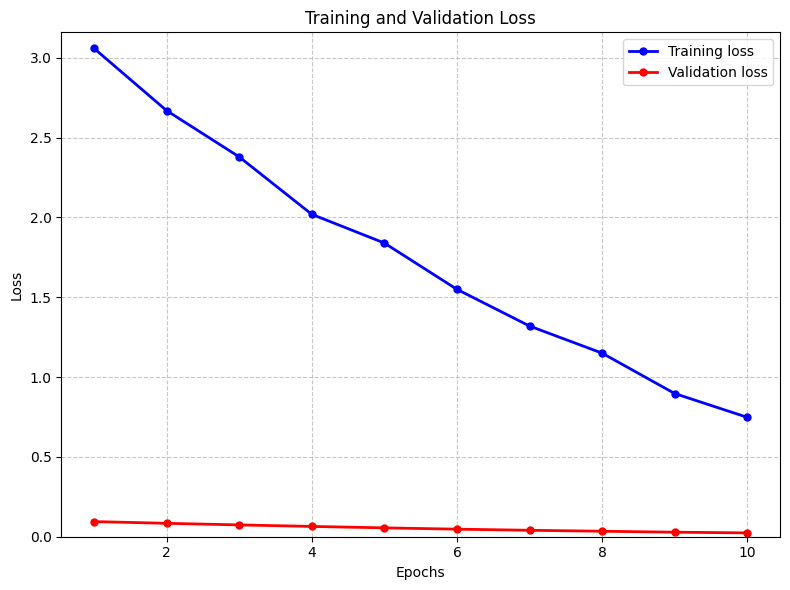

In [ ]:
import matplotlib.pyplot as plt

def plot_loss(train_loss, val_loss):
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(8, 6))  # Adjust figure size for better readability

    plt.plot(epochs, train_loss, 'bo-', label='Training loss', linewidth=2, markersize=5)
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss', linewidth=2, markersize=5)

    # Set y-axis range for better visualization
    plt.ylim(0, max(max(train_loss), max(val_loss)) + 0.1)

    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.grid(True, linestyle='--', alpha=0.7)  # Add grid for better readability
    plt.tight_layout()  # Ensure everything fits without overlapping

    # Save the plot as an image (optional)
    # plt.savefig('training_validation_loss.png', dpi=300)

    plt.show()

# Example usage
train_loss = [3.06, 2.67, 2.38, 2.02, 1.84, 1.55, 1.32, 1.15, 0.897, 0.748]
val_loss = [0.0949, 0.0840, 0.0740, 0.0645, 0.0555, 0.0474, 0.0403, 0.0344, 0.0283, 0.0240]

plot_loss(train_loss, val_loss)


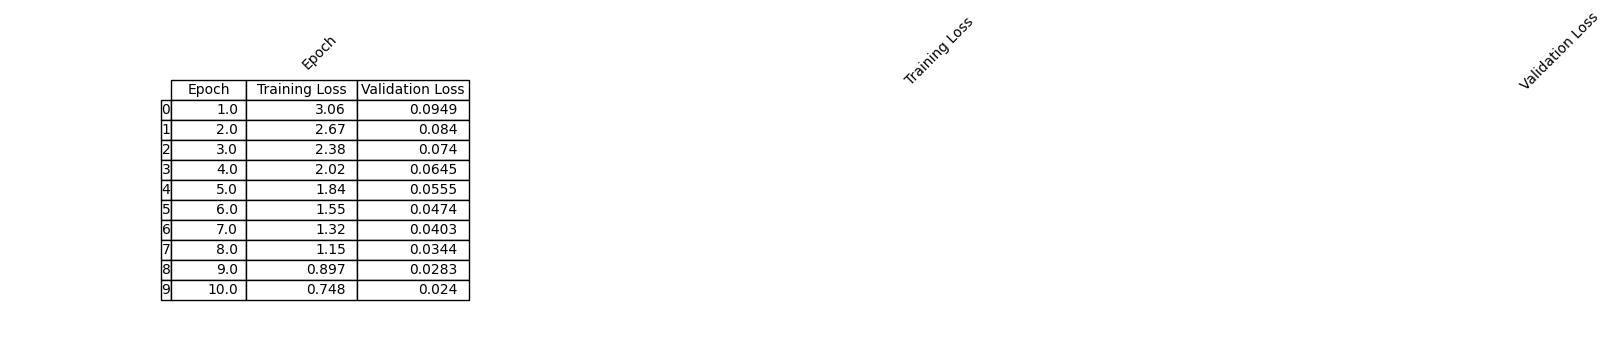

In [ ]:
import matplotlib.pyplot as plt
from pandas.plotting import table

train_loss = [3.06, 2.67, 2.38, 2.02, 1.84, 1.55, 1.32, 1.15, 0.897, 0.748]
val_loss = [0.0949, 0.0840, 0.0740, 0.0645, 0.0555, 0.0474, 0.0403, 0.0344, 0.0283, 0.0240]

# Create a DataFrame for the table
import pandas as pd
df = pd.DataFrame({
    'Epoch': range(1, 11),
    'Training Loss': train_loss,
    'Validation Loss': val_loss
})

# Convert 'Epoch' column to integers
df['Epoch'] = df['Epoch'].astype(int)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

# Hide the axes
ax.axis('off')

# Create the table and add it to the axis
tab = table(ax, df, loc='center', colWidths=[0.1, 0.15, 0.15])
tab.auto_set_font_size(False)
tab.set_fontsize(10)
tab.scale(1.2, 1.2)

# Rotate the column titles for better visibility
for i, key in enumerate(df.columns):
    ax.text(i + 0.5, 0.95, key, ha='center', va='center', rotation=45)

# Save the figure as an image
plt.savefig('loss_table.png', bbox_inches='tight', pad_inches=0.05)
plt.show()


## Decision Matrix

In [ ]:
# !pip install seaborn
# import seaborn
import numpy as np
accumulatedArray = np.zeros((55,55))

# Run through images in the test dataset
# Loop through pixels and update accumulatedArray
# i index represents the true pixel label
# j index represents the predicted pixel lab


# for row in range(WIDTH):
  # for col in range(HEIGHT):
      # get row, col value from both true image and predicted image

      # true_value = real_image[row][col]
      # predicted_value = prediction[row][col]
      # i is real classification, j is prediction classification
      # incremenet value in accumulatedArray,
      # accumulatedArray[true_value][predicted_value] += 1


In [ ]:
print(accumulatedArray)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


[[31.91876499 20.63059873  9.05016055 14.65951203]
 [20.23406183 32.35124313 48.28293508 47.19382895]
 [36.69125718 44.58779153 37.74080757 11.67833417]
 [11.15591599  2.43036661  4.92609681 26.46832486]]


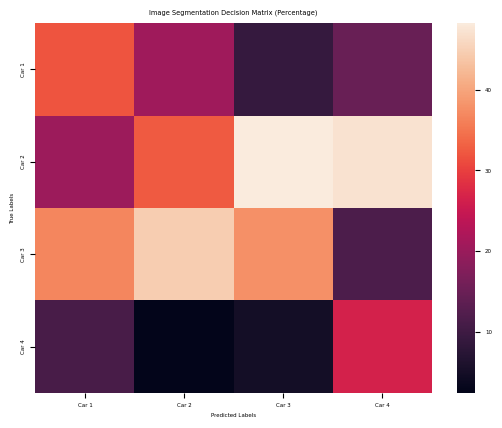

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np

def plot_matrix(data):
    axis_labels = [
        "Car 1", "Car 2", "Car 3", "Car 4",
        "Bicycle 1", "Bicycle 2", "Bicycle 3", "Bicycle 4",
        "Pedestrian 1", "Pedestrian 2", "Pedestrian 3",
        "Truck 1", "Truck 2", "Truck 3",
        "Small vehicles 1", "Small vehicles 2", "Small vehicles 3",
        "Traffic signal 1", "Traffic signal 2", "Traffic signal 3",
        "Traffic sign 1", "Traffic sign 2", "Traffic sign 3",
        "Utility vehicle 1", "Utility vehicle 2",
        "Sidebars", "Speed bumper", "Curbstone", "Solid line",
        "Irrelevant signs", "Road blocks", "Tractor",
        "Non-drivable street", "Zebra crossing", "Obstacles / trash", "Poles",
        "RD restricted area", "Animals", "Grid structure", "Signal corpus",
        "Drivable cobblestone", "Electronic traffic", "Slow drive area",
        "Nature object", "Parking area", "Sidewalk", "Ego car",
        "Painted driv. instr.", "Traffic guide obj.", "Dashed line",
        "RD normal street", "Sky", "Buildings", "Blurred area", "Rain dirt"
    ]

    # Create a list to store the indices of non-empty columns
    non_empty_columns = [i for i, col in enumerate(data.T) if any(col)]

    # Remove empty columns and corresponding rows
    data_filtered = data[:, non_empty_columns]
    axis_labels_filtered = [label for i, label in enumerate(axis_labels) if i in non_empty_columns]

    # Normalize each row to represent the percentage of the total in its row
    data_percentage = (data_filtered.T / data_filtered.sum(axis=1)).T * 100

    # Calculate column sums
    col_sums = np.sum(data_filtered, axis=0)

    # Convert data to percentages
    percentage_matrix = (data_filtered / col_sums) * 100

    # Create the heatmap
    hm = sn.heatmap(data=percentage_matrix, xticklabels=axis_labels_filtered, yticklabels=axis_labels_filtered)

    print(percentage_matrix)
    # Set the font size
    font = {'size': 4}
    plt.rc('font', **font)

    # Set the title and labels
    plt.title("Image Segmentation Decision Matrix (Percentage)")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")

    # Display the figure
    plt.show()

# Example usage
# Sample data
data_array = np.random.rand(4, 4)
plot_matrix(data_array)


In [ ]:
plot_matrix(accumulatedArray)

ValueError: zero-size array to reduction operation fmin which has no identity

In [ ]:
import numpy as np

# Specify the path to your file
file_path = "/content/drive/MyDrive/Archie/final_array.txt"  # Replace with the actual path to your file

# Load the data from the file into a numpy array
accumulatedArray = np.loadtxt(file_path)

# Print the array to check the result
# print(data_array)


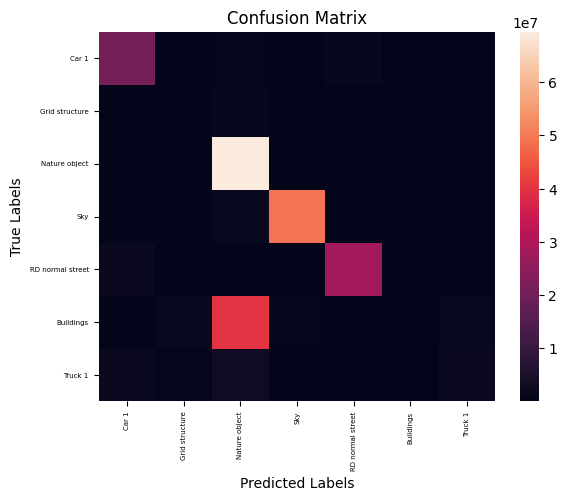

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt

selected_classes = ["Car 1", "Grid structure", "Nature object", "Sky", "RD normal street", "Buildings", "Truck 1"]

axis_labels = [
        "Car 1", "Car 2", "Car 3", "Car 4",
        "Bicycle 1", "Bicycle 2", "Bicycle 3", "Bicycle 4",
        "Pedestrian 1", "Pedestrian 2", "Pedestrian 3",
        "Truck 1", "Truck 2", "Truck 3",
        "Small vehicles 1", "Small vehicles 2", "Small vehicles 3",
        "Traffic signal 1", "Traffic signal 2", "Traffic signal 3",
        "Traffic sign 1", "Traffic sign 2", "Traffic sign 3",
        "Utility vehicle 1", "Utility vehicle 2",
        "Sidebars", "Speed bumper", "Curbstone", "Solid line",
        "Irrelevant signs", "Road blocks", "Tractor",
        "Non-drivable street", "Zebra crossing", "Obstacles / trash", "Poles",
        "RD restricted area", "Animals", "Grid structure", "Signal corpus",
        "Drivable cobblestone", "Electronic traffic", "Slow drive area",
        "Nature object", "Parking area", "Sidewalk", "Ego car",
        "Painted driv. instr.", "Traffic guide obj.", "Dashed line",
        "RD normal street", "Sky", "Buildings", "Blurred area", "Rain dirt"
    ]


selected_indices = [axis_labels.index(class_name) for class_name in selected_classes]
selected_accumulatedArray = accumulatedArray[selected_indices][:, selected_indices]
selected_axis_labels = [axis_labels[i] for i in selected_indices]

hm = sn.heatmap(data=selected_accumulatedArray, xticklabels=selected_axis_labels, yticklabels=selected_axis_labels)

plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels", fontsize=10)
plt.ylabel("True Labels", fontsize=10)
plt.tick_params(axis='both', labelsize=5)
plt.show()

### Image cropper

In [ ]:
from PIL import Image
import os

def resize_images_to_height(directory, target_height=512):
    for filename in os.listdir(directory):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp')):
            img_path = os.path.join(directory, filename)
            with Image.open(img_path) as img:
                # Calculate the new width while maintaining the aspect ratio
                aspect_ratio = img.width / img.height
                new_width = int(target_height * aspect_ratio)

                # Resize the image
                resized_img = img.resize((new_width, target_height), Image.ANTIALIAS)

                # Save the resized image
                resized_img.save(os.path.join(directory, filename))

# Example usage:
directory_path = '/content/drive/MyDrive/Archie/edgecases'
resize_images_to_height(directory_path)


<ipython-input-3-9caeb2ebfb9a>:14: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_img = img.resize((new_width, target_height), Image.ANTIALIAS)
